# Predicting Apple Inc. Stock Prices Using LSTM Networks: Achieving High Accuracy and Performance.

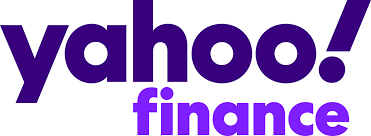

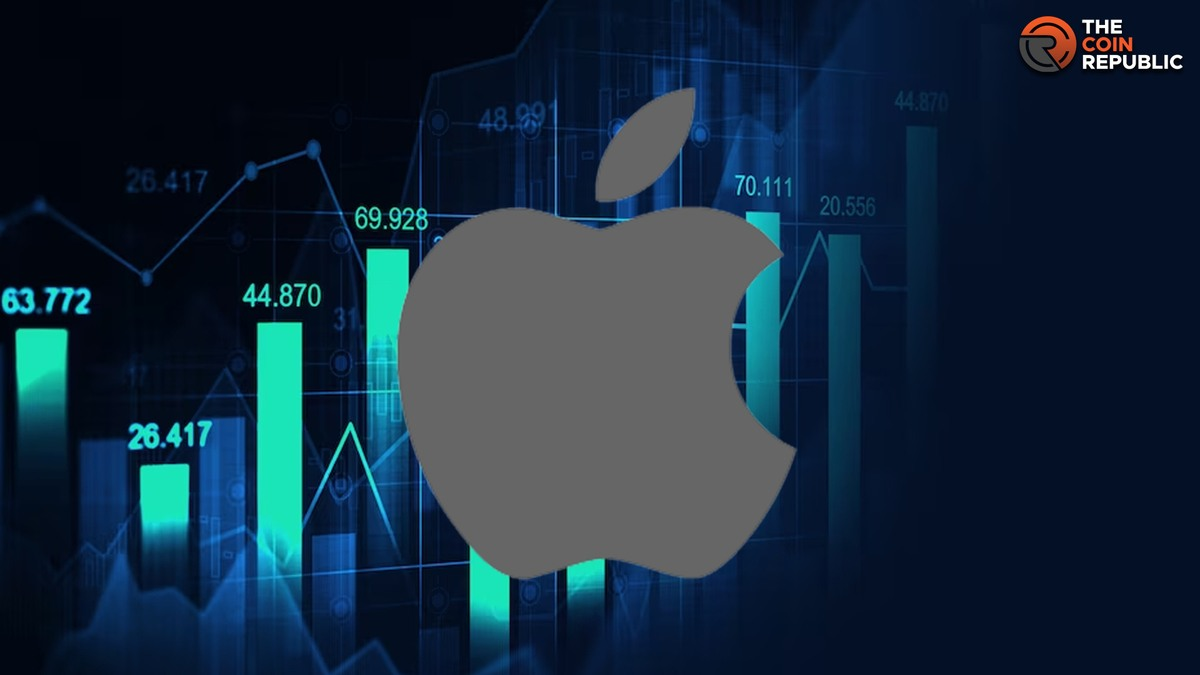

## Introduction

The financial markets are characterized by their complexity and dynamic nature, making accurate stock price prediction a challenging task. Advanced machine learning techniques, such as Long Short-Term Memory (LSTM) networks, have shown great promise in capturing the temporal dependencies and non-linear patterns inherent in stock price data. In this project, we utilize LSTM networks to predict the stock prices of Apple Inc. (AAPL) by leveraging historical stock price data.

### Objective

The primary objective of this project is to develop and evaluate an LSTM-based model to predict the future stock prices of Apple Inc. (AAPL). The model aims to achieve high accuracy in its predictions by effectively learning from historical stock price data. Specifically, the project focuses on achieving the following:

1. **High Predictive Accuracy**: By training the LSTM model on historical stock data, we aim to minimize the prediction error and maximize the accuracy of the stock price forecasts.
2. **Performance Metrics**: Evaluate the model performance using key metrics such as R2 score and Mean Absolute Error (MAE) to ensure the reliability of the predictions.
3. **Feature Utilization**: Leverage key stock price features including 'Open', 'High', 'Low', 'Close', 'Adj Close', and 'Volume' to capture the full scope of market movements.



### Import all the required libraries

In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping


### Loading The Historical Stock Price from Yahoo Finance.

In [14]:
Start_date='2015-01-01'
end_date = dt.date.today().strftime('%Y-%m-%d')

# Lets Create a Function to load Stock data fore required Ticker

def load_stocks(ticker):
    stocks_data=yf.download(ticker,Start_date,end_date)
    stocks_data.reset_index(inplace=True)
    return stocks_data


In [15]:
data=load_stocks('AAPL')

[*********************100%%**********************]  1 of 1 completed


In [18]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.402172,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.714720,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.716963,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.049522,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.973560,237458000


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2397 entries, 0 to 2396
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2397 non-null   datetime64[ns]
 1   Open       2397 non-null   float64       
 2   High       2397 non-null   float64       
 3   Low        2397 non-null   float64       
 4   Close      2397 non-null   float64       
 5   Adj Close  2397 non-null   float64       
 6   Volume     2397 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 131.2 KB


In [20]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

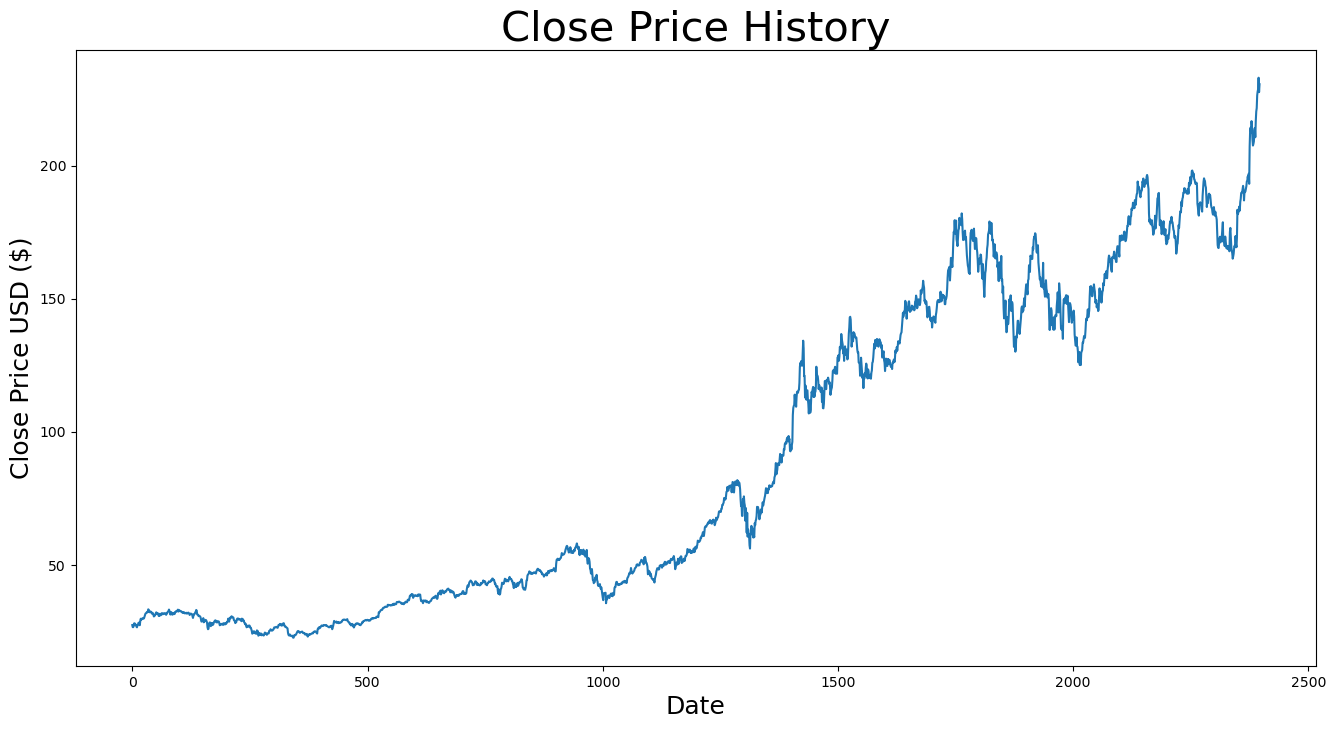

In [27]:
# Plot the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History',fontsize=30)
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [31]:
data.columns[1::]

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

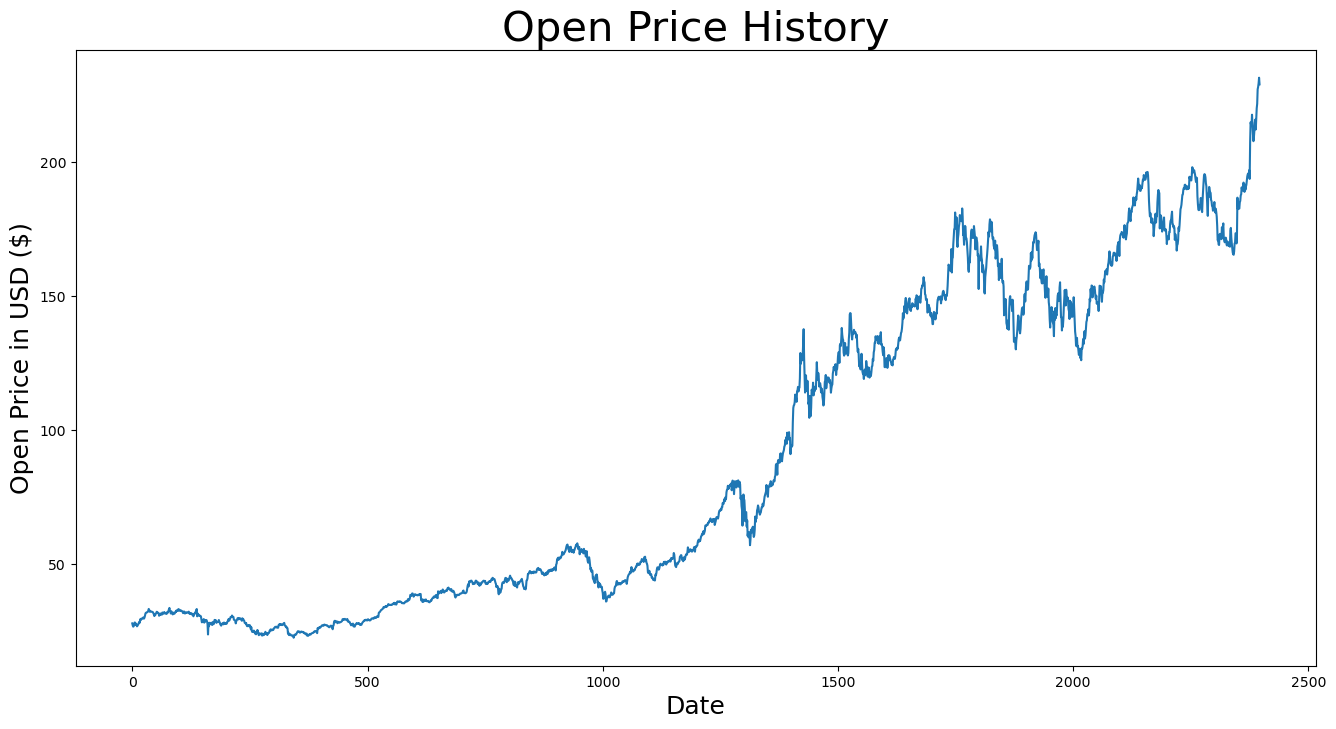

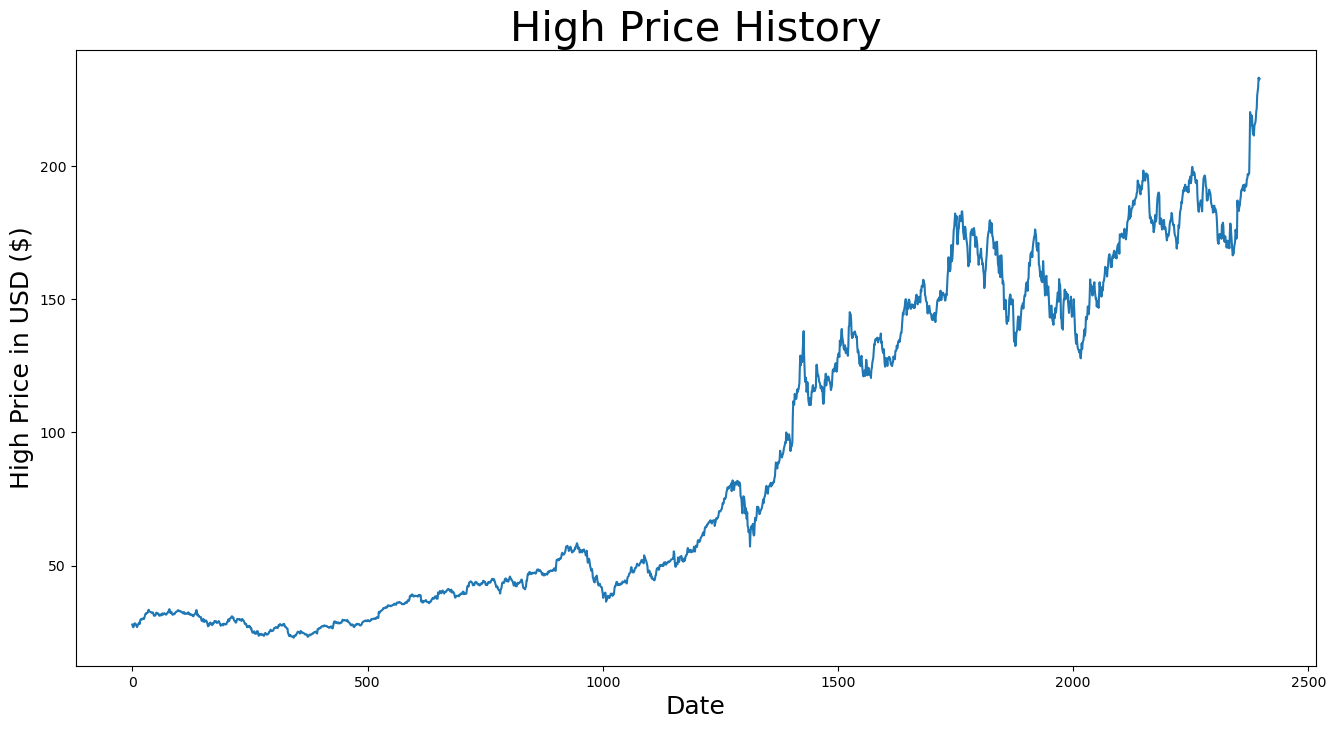

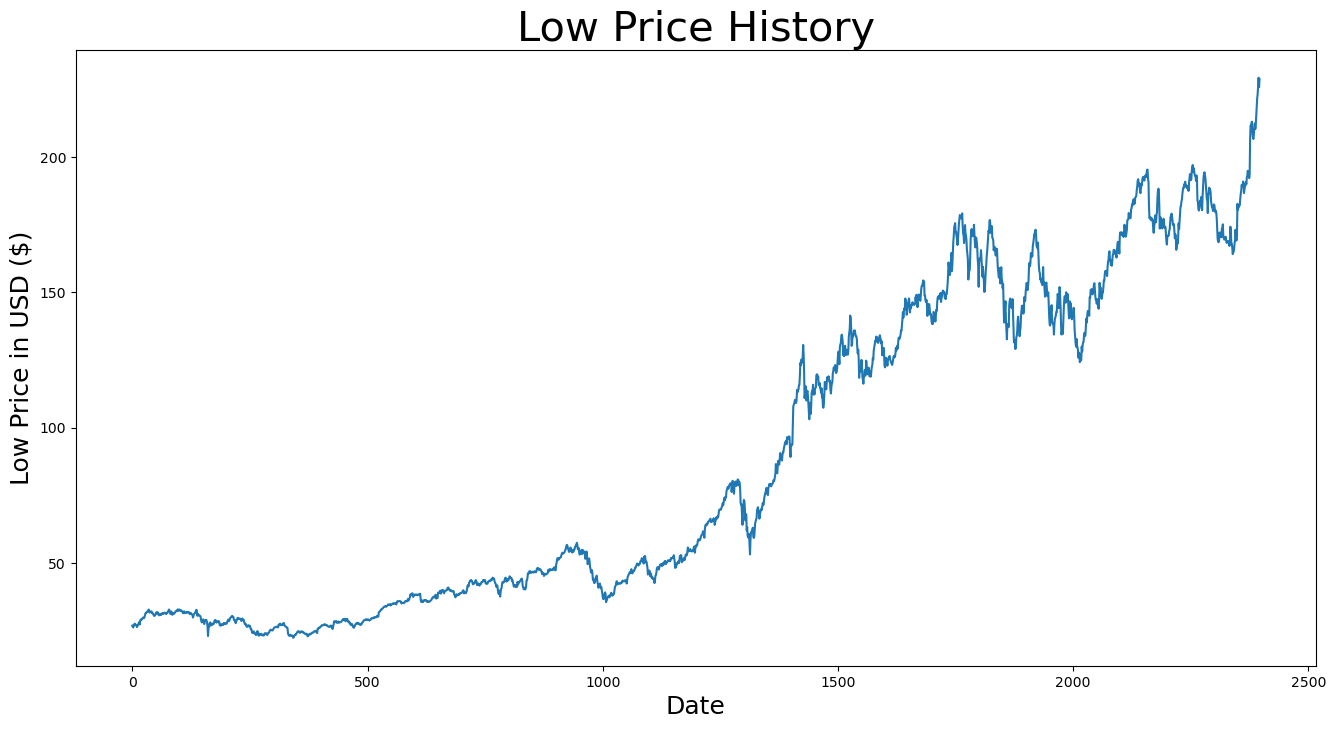

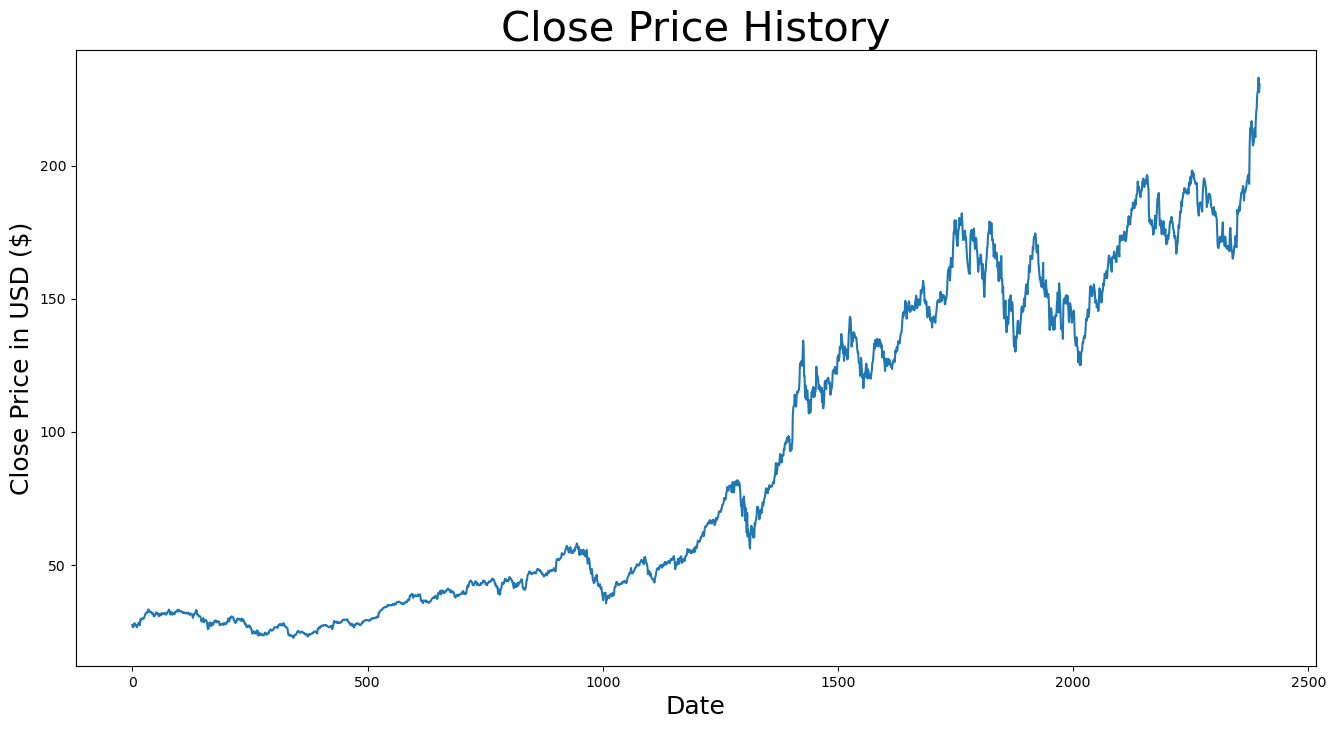

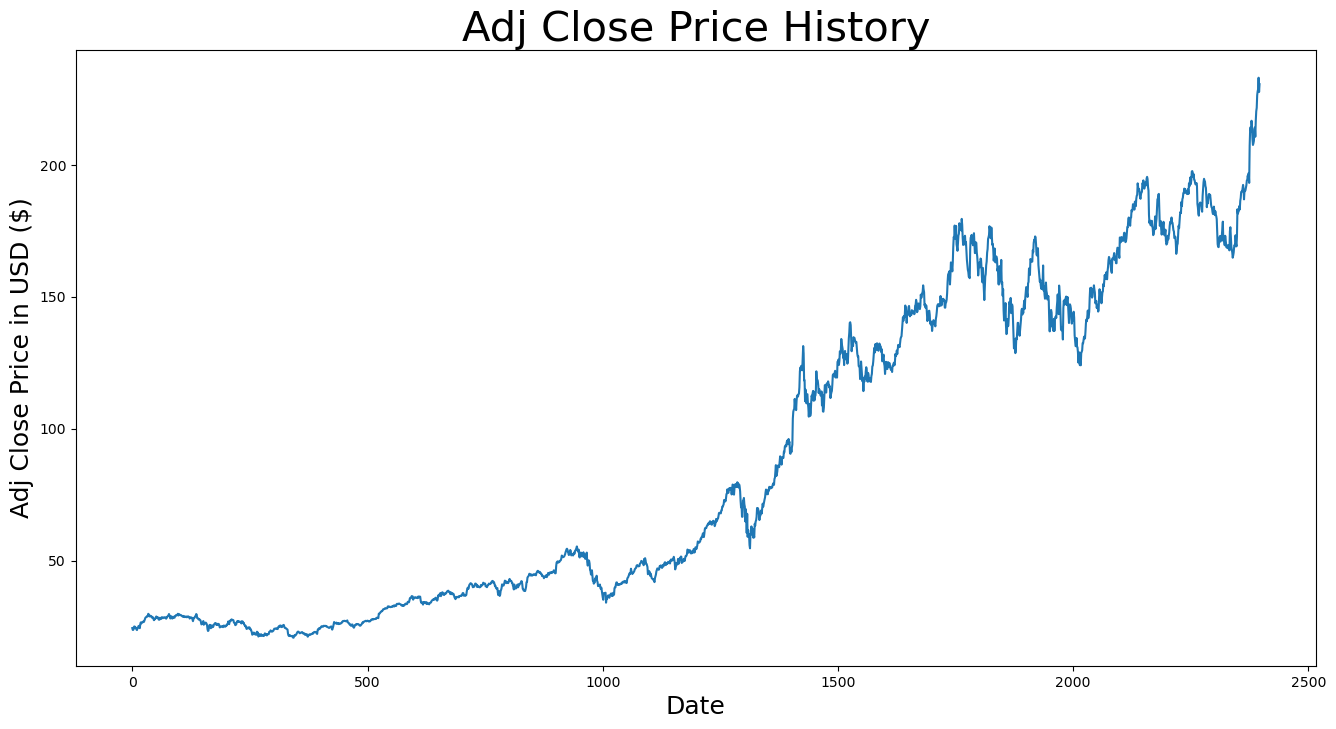

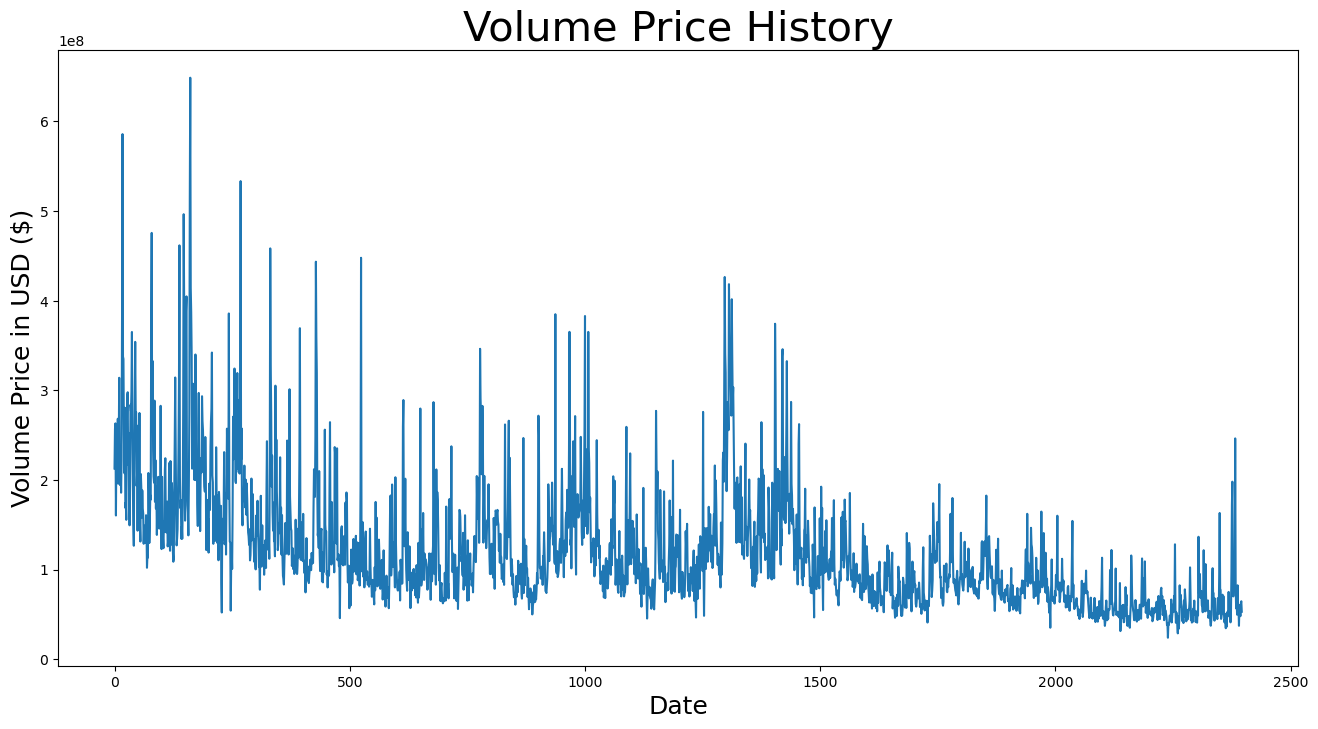

In [35]:
for i in data.columns[1::]:
    plt.figure(figsize=(16,8))
    plt.title(f"{i} Price History",fontsize=30)
    plt.plot(data[i])
    plt.xlabel('Date',fontsize=18)
    plt.ylabel(f"{i} Price in USD ($)",fontsize=18)
    plt.show()

In [43]:
stocks_data=data.filter(['Close'])

In [44]:
stocks_data

,Close
0,27.332500
1,26.562500
2,26.565001
3,26.937500
4,27.972500
...,...
2392,227.820007
2393,228.679993
2394,232.979996
2395,227.570007


In [49]:
ma_100=data['Close'].rolling(100).mean()
ma_100

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
2392    185.0734
2393    185.5098
2394    185.9981
2395    186.4352
2396    186.9175
Name: Close, Length: 2397, dtype: float64

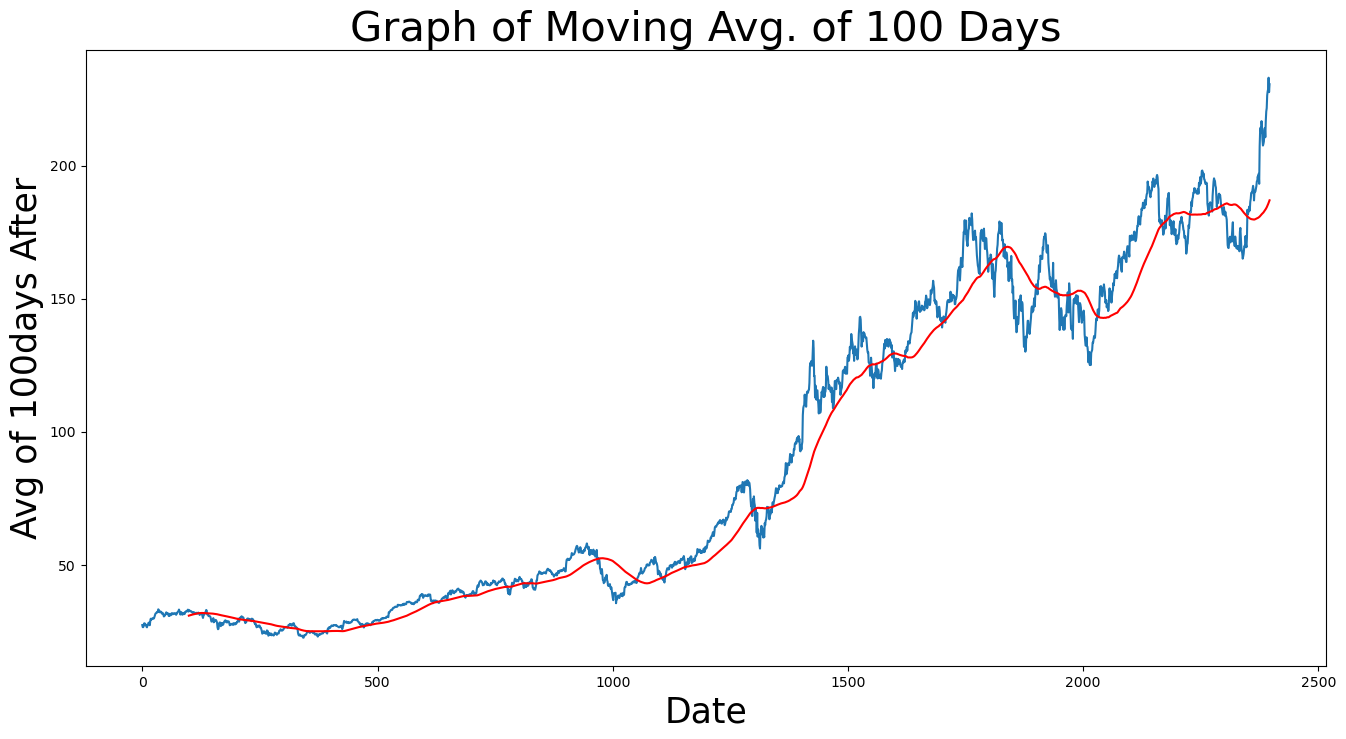

In [52]:
plt.figure(figsize=(16,8))
plt.plot(data['Close'])
plt.plot(ma_100,'r')
plt.title("Graph of Moving Avg. of 100 Days",fontsize=30)
plt.xlabel('Date',fontsize=25)
plt.ylabel('Avg of 100days After',fontsize=25)
plt.show()

In [53]:
ma_200=data['Close'].rolling(200).mean()
ma_200

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
2392    184.84950
2393    185.11545
2394    185.41070
2395    185.67460
2396    185.94690
Name: Close, Length: 2397, dtype: float64

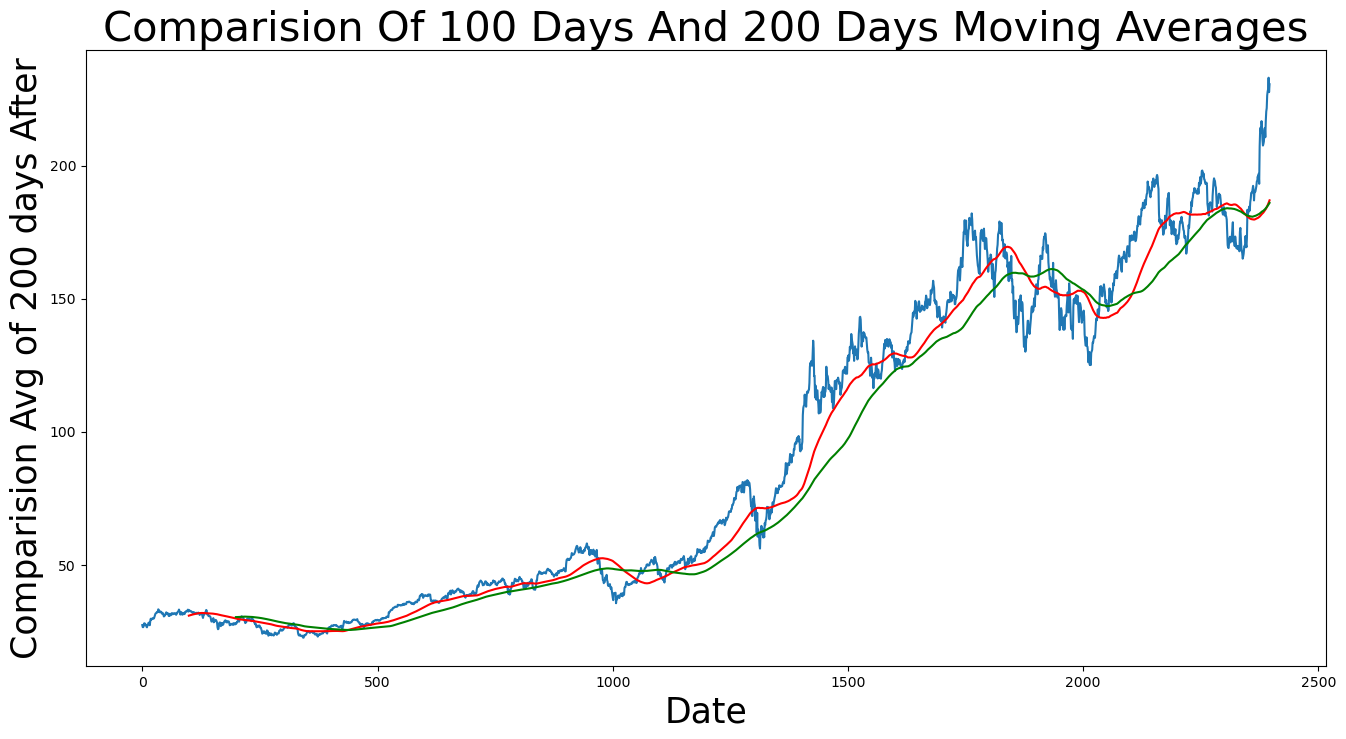

In [57]:
plt.figure(figsize=(16,8))
plt.plot(data['Close'])
plt.plot(ma_100,'r')
plt.plot(ma_200,'green')
plt.title("Comparision Of 100 Days And 200 Days Moving Averages",fontsize=30)
plt.xlabel('Date',fontsize=25)
plt.ylabel('Comparision Avg of 200 days After',fontsize=25)
plt.show()

# Preprocess Data

#### Normalize the data and Create sequences for the  LSTM model.

# Spliting the dataset into training (70%) and testing (30%)

In [59]:
train=pd.DataFrame(data[0:int(len(data)*0.70)])
test=pd.DataFrame(data[int(len(data)*0.70):int(len(data))])

print(train.shape)
print(test.shape)

(1677, 7)
(720, 7)


In [60]:
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.402172,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.714720,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.716963,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.049522,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.973560,237458000


In [61]:
test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1677,2021-08-31,152.660004,152.800003,151.289993,151.830002,149.502258,86453100
1678,2021-09-01,152.830002,154.979996,152.339996,152.509995,150.171829,80313700
1679,2021-09-02,153.869995,154.720001,152.399994,153.649994,151.294327,71115500
1680,2021-09-03,153.759995,154.630005,153.089996,154.300003,151.934372,57808700
1681,2021-09-07,154.970001,157.259995,154.389999,156.690002,154.287750,82278300


# Using Minmax Scaler for Normalization of the dataset.

In [71]:
scaler=MinMaxScaler(feature_range=(0,1))
train_close=train[['Close']].values
test_close=test[['Close']].values

In [84]:
data_train_array=scaler.fit_transform(train_close)
data_train_array


array([[0.03636957],
       [0.03047076],
       [0.03048992],
       ...,
       [0.95725283],
       [0.96537335],
       [1.        ]])

In [85]:
X_train=[]
y_train=[]


for i in range(100,data_train_array.shape[0]):
    X_train.append(data_train_array[i-100:i])
    y_train.append(data_train_array[i,0])
    
X_train,y_train=np.array(X_train),np.array(y_train)

In [86]:
X_train.shape

(1577, 100, 1)

In [87]:
y_train.shape

(1577,)

# LSTM Model Bulidig

# Training the model

In [88]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Set early stopping criteria
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=20, callbacks=[early_stop])


Epoch 1/20
1577/1577 [==============================] - 58s 35ms/step - loss: 0.0020
Epoch 2/20
1577/1577 [==============================] - 55s 35ms/step - loss: 9.0756e-04
Epoch 3/20
1577/1577 [==============================] - 55s 35ms/step - loss: 5.8922e-04
Epoch 4/20
1577/1577 [==============================] - 56s 36ms/step - loss: 5.8994e-04
Epoch 5/20
1577/1577 [==============================] - 56s 36ms/step - loss: 4.8918e-04
Epoch 6/20
1577/1577 [==============================] - 53s 33ms/step - loss: 4.4882e-04
Epoch 7/20
1577/1577 [==============================] - 54s 34ms/step - loss: 3.8560e-04
Epoch 8/20
1577/1577 [==============================] - 55s 35ms/step - loss: 3.3268e-04
Epoch 9/20
1577/1577 [==============================] - 62s 39ms/step - loss: 2.6856e-04
Epoch 10/20
1577/1577 [==============================] - 58s 37ms/step - loss: 3.3405e-04
Epoch 11/20
1577/1577 [==============================] - 57s 36ms/step - loss: 2.6149e-04
Epoch 12/20
1577/1577 [

In [106]:
model.save('keras_model.h5')

C:\Users\DELL\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [107]:
test_close.shape

(720, 1)

In [108]:
test_close

array([[151.83000183],
       [152.50999451],
       [153.6499939 ],
       [154.30000305],
       [156.69000244],
       [155.11000061],
       [154.07000732],
       [148.97000122],
       [149.55000305],
       [148.11999512],
       [149.02999878],
       [148.78999329],
       [146.05999756],
       [142.94000244],
       [143.42999268],
       [145.8500061 ],
       [146.83000183],
       [146.91999817],
       [145.36999512],
       [141.91000366],
       [142.83000183],
       [141.5       ],
       [142.6499939 ],
       [139.13999939],
       [141.11000061],
       [142.        ],
       [143.28999329],
       [142.8999939 ],
       [142.80999756],
       [141.50999451],
       [140.91000366],
       [143.75999451],
       [144.83999634],
       [146.55000305],
       [148.75999451],
       [149.25999451],
       [149.47999573],
       [148.69000244],
       [148.63999939],
       [149.32000732],
       [148.8500061 ],
       [152.57000732],
       [149.80000305],
       [148

In [109]:
past_100_days = pd.DataFrame(train_close[-100:])

In [110]:
test_df = pd.DataFrame(test_close)

In [111]:
test_df

,0
0,151.830002
1,152.509995
2,153.649994
3,154.300003
4,156.690002
...,...
715,227.820007
716,228.679993
717,232.979996
718,227.570007


### Defining the final dataset for testing by including last 100 coloums of the training dataset to get the prediction from the 1st column of the testing dataset.

In [112]:
final_df = past_100_days.append(test_df, ignore_index = True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_19908\1505569079.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_100_days.append(test_df, ignore_index = True)


In [113]:
final_df.head()

,0
0,133.000000
1,131.240005
2,134.429993
3,132.029999
4,134.500000


In [114]:
input_data = scaler.fit_transform(final_df)
input_data

array([[0.09282282],
       [0.07685336],
       [0.10579799],
       [0.08402143],
       [0.1064332 ],
       [0.10334822],
       [0.10951819],
       [0.09382092],
       [0.09735962],
       [0.08320484],
       [0.10480003],
       [0.1084294 ],
       [0.1054351 ],
       [0.09808552],
       [0.09717811],
       [0.07884956],
       [0.08864891],
       [0.04609384],
       [0.0483623 ],
       [0.06324298],
       [0.06750758],
       [0.03702025],
       [0.02849113],
       [0.        ],
       [0.01996193],
       [0.04246439],
       [0.03175755],
       [0.01887308],
       [0.01742134],
       [0.04119409],
       [0.02413577],
       [0.03928865],
       [0.03747396],
       [0.03702025],
       [0.02277472],
       [0.01669544],
       [0.01370114],
       [0.02077852],
       [0.0069867 ],
       [0.02830962],
       [0.02840037],
       [0.03602215],
       [0.03956084],
       [0.03030582],
       [0.04155704],
       [0.06995735],
       [0.06233557],
       [0.066

In [115]:
input_data.shape

(820, 1)

# Testing the model

In [117]:
X_test = []
y_test = []
for i in range(100, input_data.shape[0]):
    X_test.append(input_data[i-100: i])
    y_test.append(input_data[i, 0])

In [118]:
X_test,y_test=np.array(X_test),np.array(y_test)

In [119]:
print(X_test.shape)
print(y_test.shape)

(720, 100, 1)
(720,)


# Making prediction and plotting the graph of predicted vs actual values

In [120]:
y_pred=model.predict(X_test)

23/23 [==============================] - 1s 35ms/step


In [121]:
y_pred.shape

(720, 1)

In [122]:
y_test

array([0.26367848, 0.26984845, 0.28019234, 0.28609025, 0.30777612,
       0.29343984, 0.28400337, 0.23772802, 0.24299071, 0.23001541,
       0.23827241, 0.2360947 , 0.21132385, 0.1830143 , 0.18746027,
       0.20941847, 0.21831055, 0.21912714, 0.20506305, 0.17366852,
       0.1820162 , 0.16994831, 0.18038288, 0.14853464, 0.16640962,
       0.17448511, 0.18618997, 0.18265128, 0.18183469, 0.170039  ,
       0.16459493, 0.19045457, 0.20025406, 0.21576995, 0.2358225 ,
       0.2403593 , 0.2423555 , 0.23518742, 0.23473372, 0.24090383,
       0.23663923, 0.27039299, 0.24525911, 0.23763733, 0.24725531,
       0.2605935 , 0.25578451, 0.25868798, 0.2510662 , 0.25442338,
       0.22820072, 0.22774702, 0.24698311, 0.2470738 , 0.25614739,
       0.27874067, 0.31848289, 0.34280017, 0.34706477, 0.35060346,
       0.35541245, 0.30886491, 0.33998738, 0.38589971, 0.38109072,
       0.37192631, 0.35450504, 0.38608122, 0.4392523 , 0.47463938,
       0.46992107, 0.51429091, 0.48062798, 0.46783419, 0.51292

In [123]:
y_pred

array([[0.2669784 ],
       [0.2671107 ],
       [0.27123088],
       [0.2801539 ],
       [0.28706047],
       [0.30522266],
       [0.29912964],
       [0.29001245],
       [0.25306362],
       [0.246315  ],
       [0.2355882 ],
       [0.23866093],
       [0.23816535],
       [0.21975178],
       [0.19382086],
       [0.18981045],
       [0.2055484 ],
       [0.21693178],
       [0.22051916],
       [0.21108729],
       [0.18553266],
       [0.18420246],
       [0.17571464],
       [0.18066397],
       [0.15922952],
       [0.16543214],
       [0.1737794 ],
       [0.18465841],
       [0.18510681],
       [0.18447384],
       [0.1757733 ],
       [0.1692717 ],
       [0.18633285],
       [0.1986671 ],
       [0.21322656],
       [0.23201987],
       [0.24047452],
       [0.2440534 ],
       [0.23958436],
       [0.23785424],
       [0.24192145],
       [0.23982972],
       [0.26425427],
       [0.2522849 ],
       [0.24280164],
       [0.24742413],
       [0.25896642],
       [0.258

In [124]:
scaler.scale_

array([0.00907359])

In [125]:
scale_factor=1/scaler.scale_

y_pred = y_pred * scale_factor

y_test = y_test * scale_factor

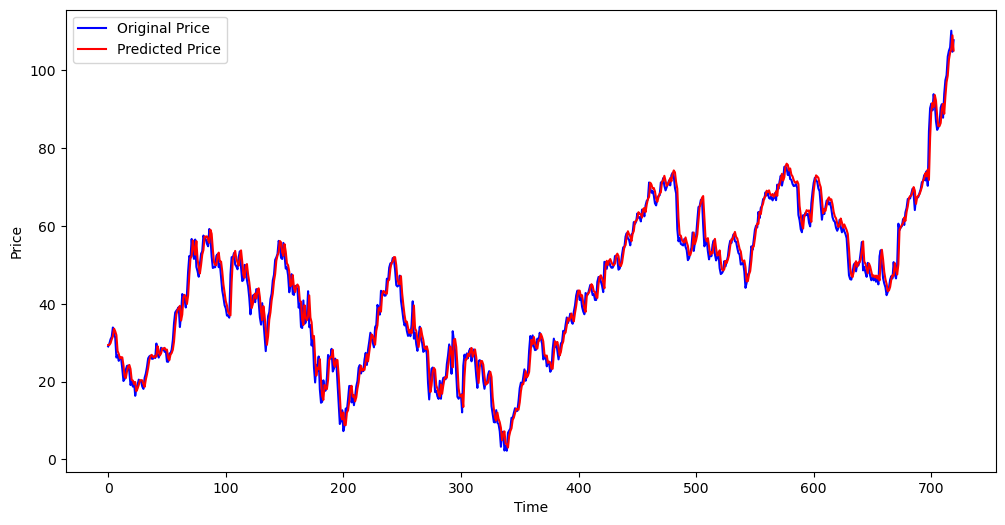

In [126]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [127]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error on test set: ", mae)

Mean absolute error on test set:  2.2493713726662383


# Calculation of R2 score

In [128]:
from sklearn.metrics import r2_score

# Actual values
actual = y_test

# Predicted values
predicted = y_pred

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 0.9771650634993241


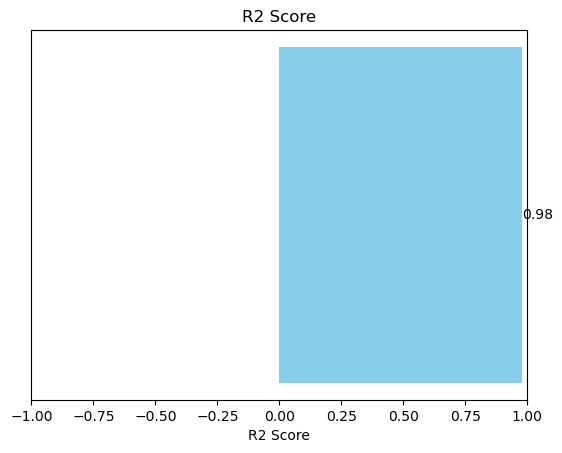

In [129]:
# Plotting the R2 score
fig, ax = plt.subplots()
ax.barh(0, r2, color='skyblue')
ax.set_xlim([-1, 1])
ax.set_yticks([])
ax.set_xlabel('R2 Score')
ax.set_title('R2 Score')

# Adding the R2 score value on the bar
ax.text(r2, 0, f'{r2:.2f}', va='center', color='black')

plt.show()

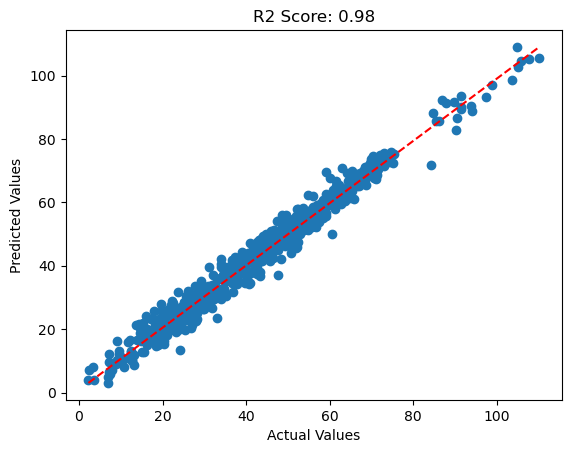

In [130]:

plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()


### Conclusion

In this project, we developed a Long Short-Term Memory (LSTM) model to predict the stock prices of Apple Inc. (AAPL) using historical stock data. The LSTM model demonstrated exceptional performance, achieving an R2 score of 0.98 and a Mean Absolute Error (MAE) of 2.25. These metrics indicate that the model is highly accurate in capturing the trends and patterns in the stock price data.

#### Key Points:
1. **High R2 Score**: The R2 score of 0.98 signifies that 98% of the variance in the stock price data is explained by the model. This high value reflects the model's strong ability to fit the data.
2. **Low MAE**: The Mean Absolute Error (MAE) of 2.25 indicates that, on average, the model's predictions are off by only $2.25 from the actual stock prices. This low error further underscores the model's accuracy.

#### Features Used:
- Historical stock prices including 'Open', 'High', 'Low', 'Close', 'Adj Close', and 'Volume'.
- Data from the period 2015-01-01 to 2023-01-01.

#### Model Architecture:
- **Preprocessing**: The data was normalized and sequences were created to prepare it for the LSTM model.
- **LSTM Layers**: The model consisted of two LSTM layers followed by Dense layers, designed to capture temporal dependencies in the stock price data.
- **Training**: The model was trained using an Adam optimizer and mean squared error loss function, with early stopping to prevent overfitting.

#### Visualization:
- Plotted historical stock prices to visually assess the data trends.
- Compared predicted stock prices with actual prices to evaluate model performance.

### Conclusion Statement:

The LSTM model built for predicting Apple Inc. (AAPL) stock prices has proven to be highly effective, achieving a near-perfect R2 score of 0.98 and a minimal MAE of 2.25. These results demonstrate the model's capability to accurately predict future stock prices, making it a valuable tool for financial analysis and investment decision-making. This project highlights the potential of LSTM networks in time series forecasting tasks, particularly in the domain of stock price prediction.